In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pathlib import Path
from pymatgen.core import Structure, Composition, Element

# user-friendly print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
def convert_mass_magnetization(comp: Composition, mass_magnetization: float, cgs_to_si: bool = True) -> float:
    """
    转换质量磁化率的单位，根据布尔参数决定转换方向。

    参数:
        comp: pymatgen.core.composition.Composition
            物质的化学组成，用于计算摩尔质量 (g/mol)。
        mass_magnetization: float
            当 cgs_to_si 为 True 时，表示 CGS 制的质量磁化率 (emu/g)；
            当 cgs_to_si 为 False 时，表示 SI 制的摩尔磁矩 (A·m²/mol)。
        cgs_to_si: bool, 默认 True
            转换方向选择：
                True  : 从 CGS (emu/g) 转换到 SI (A·m²/mol)
                False : 从 SI (A·m²/mol) 转换到 CGS (emu/g)

    返回:
        float: 转换后的磁化率数值，
               如果 cgs_to_si=True，单位为 A·m²/mol；
               如果 cgs_to_si=False，单位为 emu/g。
    """
    molar_mass = comp.weight  # 单位：g/mol

    if cgs_to_si:
        # 从 CGS 转换到 SI:
        # mass_magnetization (emu/g) * molar_mass (g/mol) = emu/mol
        # 1 emu = 1e-3 A·m², 所以转换为 SI 得到 A·m²/mol
        result = mass_magnetization * molar_mass * 1e-3
    else:
        # 从 SI 转换到 CGS:
        # mass_magnetization 表示 SI 制 (A·m²/mol)
        # 先转换为 emu/mol: 1 A·m² = 1e3 emu, 然后除以 molar_mass (g/mol) 得到 emu/g
        result = mass_magnetization * 1e3 / molar_mass

    return result

def convert_composition(comp: str) -> Composition:
    try:
        return Composition(comp)
    except:
        return None

def format_title(text, to_snake=False, skip_list=None):
    """
    将输入文本格式化为首字母大写格式或转换为蛇形命名法，并支持指定不需要格式化的单词
    例如: 'aaa_xxxx' -> 'Aaa xxxx' 或 'AaaXxxx' -> 'aaa_xxxx'

    Parameters
    ----------
    text : str
        输入文本
    to_snake : bool, optional
        是否转换为蛇形命名法，默认为 False
    skip_list : list of str, optional
        指定部分单词不做格式化，默认为 None

    Returns
    -------
    str
        格式化后的文本
    """
    if not isinstance(text, str):
        raise ValueError("Input must be a string")

    if text is None or text.strip() == "":
        return text

    if skip_list is None:
        skip_list = []

    if to_snake:
        # 将空格拆分为单词，并转换为蛇形命名法，保留skip_list中的单词不变
        words = text.strip().split()
        formatted = [word if word in skip_list else word.lower() for word in words]
        return "_".join(formatted)
    else:
        # 将下划线替换为空格，并分割成单词
        words = text.replace("_", " ").strip().split()
        if not words:
            return text
        # 格式化：第一个单词首字母大写，其他单词全部小写（除非在skip_list中）
        formatted = []
        for i, word in enumerate(words):
            if word in skip_list:
                formatted.append(word)
            else:
                formatted.append(word.capitalize() if i == 0 else word.lower())
        return " ".join(formatted)

#### QC AC data

In [4]:
qc_ac_dataset = pd.read_csv('../raw/properties_dataset.csv').dropna().drop(columns=['sample_name', 'figure_id', 'degree_of_approximant', 'SID'])
qc_ac_dataset = qc_ac_dataset.rename(columns={'composition': 'formula'})

# Drop Specific heat since these value is to describe the temperature derivative of the molar heat capacity or the second-order temperature effects
qc_ac_dataset = qc_ac_dataset[~qc_ac_dataset.prop_y.isin(['Specific heat', 'Specific heat capacity'])]

# Try to convert the composition string to the Composition object
qc_ac_dataset = qc_ac_dataset.assign(composition=qc_ac_dataset['formula'].apply(convert_composition)).dropna()
qc_ac_dataset = qc_ac_dataset.assign(elements=qc_ac_dataset.composition.apply(lambda c: tuple([str(e) for e in c.elements])))

# Align unit of Magnetic susceptibility
tmp = qc_ac_dataset[qc_ac_dataset.unit_y == 'emu*g^(-1)']
tmp = tmp.assign(
    unit_y='A*m**2/mol',
    y=[convert_mass_magnetization(comp, y) for comp, y in zip(tmp.composition, tmp.y)]
)
qc_ac_dataset.loc[tmp.index] = tmp

qc_ac_dataset.head(3)
qc_ac_dataset.shape

,formula,hypermaterial_type,prop_x,prop_y,unit_x,unit_y,x,y,sample_id,DOI,composition,elements
0,Y12Mg29Zn59,IQC,Temperature,Electrical resistivity,K,ohm*m,9.608498,0.000002,17976,10.1063/1.1406555,"(Y, Mg, Zn)","(Y, Mg, Zn)"
1,Y12Mg29Zn59,IQC,Temperature,Electrical resistivity,K,ohm*m,19.835030,0.000002,17976,10.1063/1.1406555,"(Y, Mg, Zn)","(Y, Mg, Zn)"
2,Y12Mg29Zn59,IQC,Temperature,Electrical resistivity,K,ohm*m,31.782880,0.000002,17976,10.1063/1.1406555,"(Y, Mg, Zn)","(Y, Mg, Zn)"


(50129, 12)

In [5]:
# temperature == 290 K
T = 290

qc_ac_dataset_rebuild = []
for _, data in qc_ac_dataset.groupby(['formula', 'prop_y', 'sample_id']):
    if data.x.min() <= T <= data.x.max():
        interp_func = interp1d(data.x, data.y, kind='linear')
        
        tmp = data.iloc[0].copy()
        tmp.x = T
        tmp.y = interp_func(T)

        qc_ac_dataset_rebuild.append(tmp)

qc_ac_dataset_rebuild = pd.DataFrame(qc_ac_dataset_rebuild).rename(
    columns={'prop_y': 'property', 'unit_y': 'unit', 'x': 'temperature', 'y': 'property_value'}
).drop(columns=['prop_x', 'unit_x'])

tmp = []
for _, data in qc_ac_dataset_rebuild.groupby(['formula', 'property']):
    tmp.append(data.max())

qc_ac_dataset_rebuild = pd.DataFrame(tmp)
qc_ac_dataset_rebuild = qc_ac_dataset_rebuild.set_index([[f'qa_{i}' for i in qc_ac_dataset_rebuild.index]], drop=True)
qc_ac_dataset_rebuild.head(3)
qc_ac_dataset_rebuild.shape
qc_ac_dataset_rebuild.property.value_counts()

,formula,hypermaterial_type,property,unit,temperature,property_value,sample_id,DOI,composition,elements
qa_0,Al61.5Cu26.5Fe12,IQC,Seebeck coefficient,V*K^(-1),290,-1.1863527516689362e-05,57966,10.1007/s11664-014-3204-4,"(Al, Cu, Fe)","(Al, Cu, Fe)"
qa_1,Al61.5Cu26.5Fe12,IQC,Thermal conductivity,W*m^(-1)*K^(-1),290,1.4258964578008275,57966,10.1007/s11664-014-3204-4,"(Al, Cu, Fe)","(Al, Cu, Fe)"
qa_2,Ag42.25In42.25Yb15.5,IQC,Electrical resistivity,ohm*m,290,2.0436187897844928e-06,35352,10.1103/physrevb.72.054202,"(Ag, In, Yb)","(Ag, In, Yb)"


(416, 10)

property
Electrical resistivity     250
Seebeck coefficient         56
Thermal conductivity        53
Magnetic susceptibility     34
Hall coefficient            11
Power factor                 7
ZT                           5
Name: count, dtype: int64

#### starry data

In [7]:
starry_dataset = pd.read_csv('../raw/starrydata_curves_20250201.csv')
starry_dataset = starry_dataset.rename(columns={'composition': 'formula'})
starry_dataset = starry_dataset.assign(
    prop_x=starry_dataset.prop_x.apply(lambda s: format_title(s, to_snake=False)),
    prop_y=starry_dataset.prop_y.apply(lambda s: format_title(s, to_snake=False, skip_list=['ZT'])),
    unit_x=starry_dataset.unit_x.apply(lambda s: format_title(s, to_snake=False)),
    unit_y=starry_dataset.unit_y.apply(lambda s: format_title(s, to_snake=False)),
)

# Drop extremely small data
starry_dataset = starry_dataset[starry_dataset.unit_x == 'K']
starry_dataset = starry_dataset[~starry_dataset.prop_y.isin(['Carrier thermal conductivity', 'Phonon thermal conductance'])]
starry_dataset = starry_dataset[starry_dataset.prop_y.isin(starry_dataset.prop_y.unique()[starry_dataset.prop_y.value_counts() >= 500])]

starry_dataset = starry_dataset[~starry_dataset.sample_id.isin([int(i) for i in qc_ac_dataset.sample_id if not i.startswith('hmt')])].assign(hypermaterial_type='others')
starry_dataset = starry_dataset[[
    'formula', 'hypermaterial_type', 'prop_x', 'prop_y', 'unit_x', 'unit_y', 'x', 'y', 'sample_id', 'DOI'
]].dropna()

# Try to convert the composition string to the Composition object
starry_dataset = starry_dataset.assign(composition=starry_dataset['formula'].apply(convert_composition)).dropna()
starry_dataset = starry_dataset.assign(elements=starry_dataset.composition.apply(lambda c: tuple([str(e) for e in c.elements])))

starry_dataset.head(3)
starry_dataset.shape

,formula,hypermaterial_type,prop_x,prop_y,unit_x,unit_y,x,y,sample_id,DOI,composition,elements
0,Pb1.00025Zn0.02Te1.02I0.0005,others,Temperature,Seebeck coefficient,K,V*k^(-1),"[299.8597,324.8683,349.8757,375.2454,399.8985,...","[-0.0001484452,-0.0001602763,-0.0001729511,-0....",113,10.1021/am405410e,"(Pb, Zn, Te, I)","(Pb, Zn, Te, I)"
1,Na0.0035Pb0.9965Se1,others,Temperature,Seebeck coefficient,K,V*k^(-1),"[317.7914,379.1411,384.0491,431.9018,452.7607,...","[0.0000727595,0.00007374922,0.00009257471,0.00...",147,10.1002/adma.201004200,"(Na, Pb, Se)","(Na, Pb, Se)"
2,Pb1.03Sb0.03Te1,others,Temperature,Seebeck coefficient,K,V*k^(-1),"[333.1159,340.5494,347.983,355.4166,362.8501,3...","[-0.0000235374,-0.00002455838,-0.00002681692,-...",434,10.1002/anie.200803934,"(Pb, Sb, Te)","(Pb, Sb, Te)"


(137677, 12)

In [8]:
starry_dataset_rebuild = []
for _, data in starry_dataset.groupby(['formula', 'prop_y', 'sample_id']):
    try:
        x, y = eval(data.x.item()), eval(data.y.item())
        
        if min(x) <= T <= max(x):
            interp_func = interp1d(x, y, kind='linear')
            
            tmp = data.iloc[0].copy()
            tmp.x = T
            tmp.y = interp_func(T)
    
            starry_dataset_rebuild.append(tmp)
    except:
        pass

starry_dataset_rebuild = pd.DataFrame(starry_dataset_rebuild).rename(
    columns={'prop_y': 'property', 'unit_y': 'unit', 'x': 'temperature', 'y': 'property_value'}
).drop(columns=['prop_x', 'unit_x'])

tmp = []
for _, data in starry_dataset_rebuild.groupby(['formula', 'property']):
    tmp.append(data.max())

starry_dataset_rebuild = pd.DataFrame(tmp)
starry_dataset_rebuild = starry_dataset_rebuild.set_index([[f'starry_{i}' for i in starry_dataset_rebuild.index]], drop=True)
starry_dataset_rebuild.head(3)
starry_dataset_rebuild.shape
starry_dataset_rebuild.property.value_counts()

,formula,hypermaterial_type,property,unit,temperature,property_value,sample_id,DOI,composition,elements
starry_0,(ErAs)0.003InGaAs,others,Thermal conductivity,W*m^(-1)*k^(-1),290,3.2670491071158483,19588,10.1063/1.2207829,"(Er, As, In, Ga)","(Er, As, In, Ga)"
starry_1,Bi2Te2.4Se0.6,others,Carrier concentration,M^(-3),290,-5.436073908332581e+24,9003,10.1103/physrevb.89.125416,"(Bi, Te, Se)","(Bi, Te, Se)"
starry_2,Bi2Te2.4Se0.6,others,Electrical conductivity,Ohm^(-1)*m^(-1),290,1063.8779641515926,9003,10.1103/physrevb.89.125416,"(Bi, Te, Se)","(Bi, Te, Se)"


(15959, 10)

property
Seebeck coefficient                4892
Electrical resistivity             4494
Thermal conductivity               2329
ZT                                 1407
Power factor                       1022
Electrical conductivity             822
Carrier concentration               370
Lattice thermal conductivity        334
Thermopower                         184
Hall mobility                        58
Electronic thermal conductivity      32
Electronic contribution              15
Name: count, dtype: int64

### MP data

In [11]:
mp_props = ['band_gap', 'composition', 'density', 'efermi', 'elements', 'final_energy_per_atom', 'formation_energy_per_atom', 'pretty_formula', 'total_magnetization', 'volume']

mp_data = pd.read_pickle("../raw/mp_inorganic_v2024.12.18.pd.xz")
mp_data = mp_data[mp_data.e_above_hull == 0.0]
mp_data = mp_data[mp_props]
mp_data = mp_data.assign(hypermaterial_type='others', composition=mp_data.composition.apply(convert_composition)).dropna()

mp_data.head(3)

,band_gap,composition,density,efermi,elements,final_energy_per_atom,formation_energy_per_atom,pretty_formula,total_magnetization,volume,hypermaterial_type
mp-1006278,0.0,"(Ac, Eu, Au)",10.961903,4.883417,"[Ac, Au, Eu]",-6.019130,-0.776843,AcEuAu2,1.627705,117.080578,others
mp-1017985,0.0,"(Ti, Ag)",7.340359,4.709549,"[Ti, Ag]",-5.429487,-0.065696,TiAg,0.000432,70.460966,others
mp-1018128,0.0,"(Sc, Ag)",7.528867,3.934398,"[Sc, Ag]",-4.301338,-0.302162,ScAg2,0.003584,57.497334,others


In [12]:
mp_data_rebuild = []
units = {
    'band_gap': 'eV',
    'density': 'g*cm^(-3)',
    'efermi': 'eV',
    'final_energy_per_atom': 'eV/atom',
    'formation_energy_per_atom': 'eV/atom',
    'total_magnetization': 'µB/f.u.',
    'volume': 'Å^3'
}
mp_props = ['band_gap', 'density', 'efermi', 'final_energy_per_atom', 'formation_energy_per_atom', 'total_magnetization', 'volume']

for p in mp_props:
    data = mp_data[['pretty_formula', 'composition', 'hypermaterial_type', 'elements', p]].rename(columns={'pretty_formula': 'formula', p: 'property_value'})
    data = data.assign(sample_id=0, DOI='-', unit=units[p], temperature=0, property=format_title(p, to_snake=False))
    mp_data_rebuild.append(data)

mp_data_rebuild = pd.concat(mp_data_rebuild)

mp_data_rebuild.head(3)
mp_data_rebuild.shape
mp_data_rebuild.property.value_counts()

,formula,composition,hypermaterial_type,elements,property_value,sample_id,DOI,unit,temperature,property
mp-1006278,AcEuAu2,"(Ac, Eu, Au)",others,"[Ac, Au, Eu]",0.0,0,-,eV,0,Band gap
mp-1017985,TiAg,"(Ti, Ag)",others,"[Ti, Ag]",0.0,0,-,eV,0,Band gap
mp-1018128,ScAg2,"(Sc, Ag)",others,"[Sc, Ag]",0.0,0,-,eV,0,Band gap


(231497, 10)

property
Band gap                     33071
Density                      33071
Efermi                       33071
Final energy per atom        33071
Formation energy per atom    33071
Total magnetization          33071
Volume                       33071
Name: count, dtype: int64

### Merge dataset

In [13]:
qc_ac_te_mp_dataset = pd.concat([qc_ac_dataset_rebuild, starry_dataset_rebuild, mp_data_rebuild])
qc_ac_te_mp_dataset.to_pickle('../raw/qc_ac_te_mp_dataset_T=290K_20250201.pd.xz')

qc_ac_te_mp_dataset.sample(5)
qc_ac_te_mp_dataset.shape
qc_ac_te_mp_dataset.property.value_counts()

,formula,hypermaterial_type,property,unit,temperature,property_value,sample_id,DOI,composition,elements
mp-1199451,B2S3,others,Volume,Å^3,0,4055.021688,0,-,"(B, S)","[B, S]"
starry_13802,SrNi2P4,others,Electrical resistivity,Ohm*m,290,1.3518052501194927e-06,1262,10.1021/acs.chemmater.5b01592,"(Sr, Ni, P)","(Sr, Ni, P)"
mp-557086,TmMoO4F,others,Band gap,eV,0,3.7429,0,-,"(Tm, Mo, O, F)","[F, Mo, O, Tm]"
mp-865963,LiGaAg2,others,Volume,Å^3,0,65.552037,0,-,"(Li, Ga, Ag)","[Li, Ga, Ag]"
mp-20224,GdInPd,others,Formation energy per atom,eV/atom,0,-0.811323,0,-,"(Gd, In, Pd)","[Gd, In, Pd]"


(247872, 10)

property
Volume                             33071
Band gap                           33071
Total magnetization                33071
Formation energy per atom          33071
Final energy per atom              33071
Efermi                             33071
Density                            33071
Seebeck coefficient                 4948
Electrical resistivity              4744
Thermal conductivity                2382
ZT                                  1412
Power factor                        1029
Electrical conductivity              822
Carrier concentration                370
Lattice thermal conductivity         334
Thermopower                          184
Hall mobility                         58
Magnetic susceptibility               34
Electronic thermal conductivity       32
Electronic contribution               15
Hall coefficient                      11
Name: count, dtype: int64

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/tmp/ipykernel_181646/2037820726.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')


[Text(0, 0, 'Thermal conductivity'),
 Text(1, 0, 'Carrier concentration'),
 Text(2, 0, 'Electrical conductivity'),
 Text(3, 0, 'Thermopower'),
 Text(4, 0, 'Electrical resistivity'),
 Text(5, 0, 'Power factor'),
 Text(6, 0, 'Seebeck coefficient'),
 Text(7, 0, 'Lattice thermal conductivity'),
 Text(8, 0, 'ZT'),
 Text(9, 0, 'Hall mobility'),
 Text(10, 0, 'Electronic contribution'),
 Text(11, 0, 'Electronic thermal conductivity')]

Text(0, 0.5, 'Count')

Text(0.5, 0, '')

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/.miniforge3/envs

[Text(0, 0, 'Seebeck coefficient'),
 Text(1, 0, 'Thermal conductivity'),
 Text(2, 0, 'Electrical resistivity'),
 Text(3, 0, 'Magnetic susceptibility'),
 Text(4, 0, 'Specific heat capacity'),
 Text(5, 0, 'Hall coefficient'),
 Text(6, 0, 'ZT'),
 Text(7, 0, 'Power factor')]

Text(0.5, 0, '')

Text(0, 0.5, '')

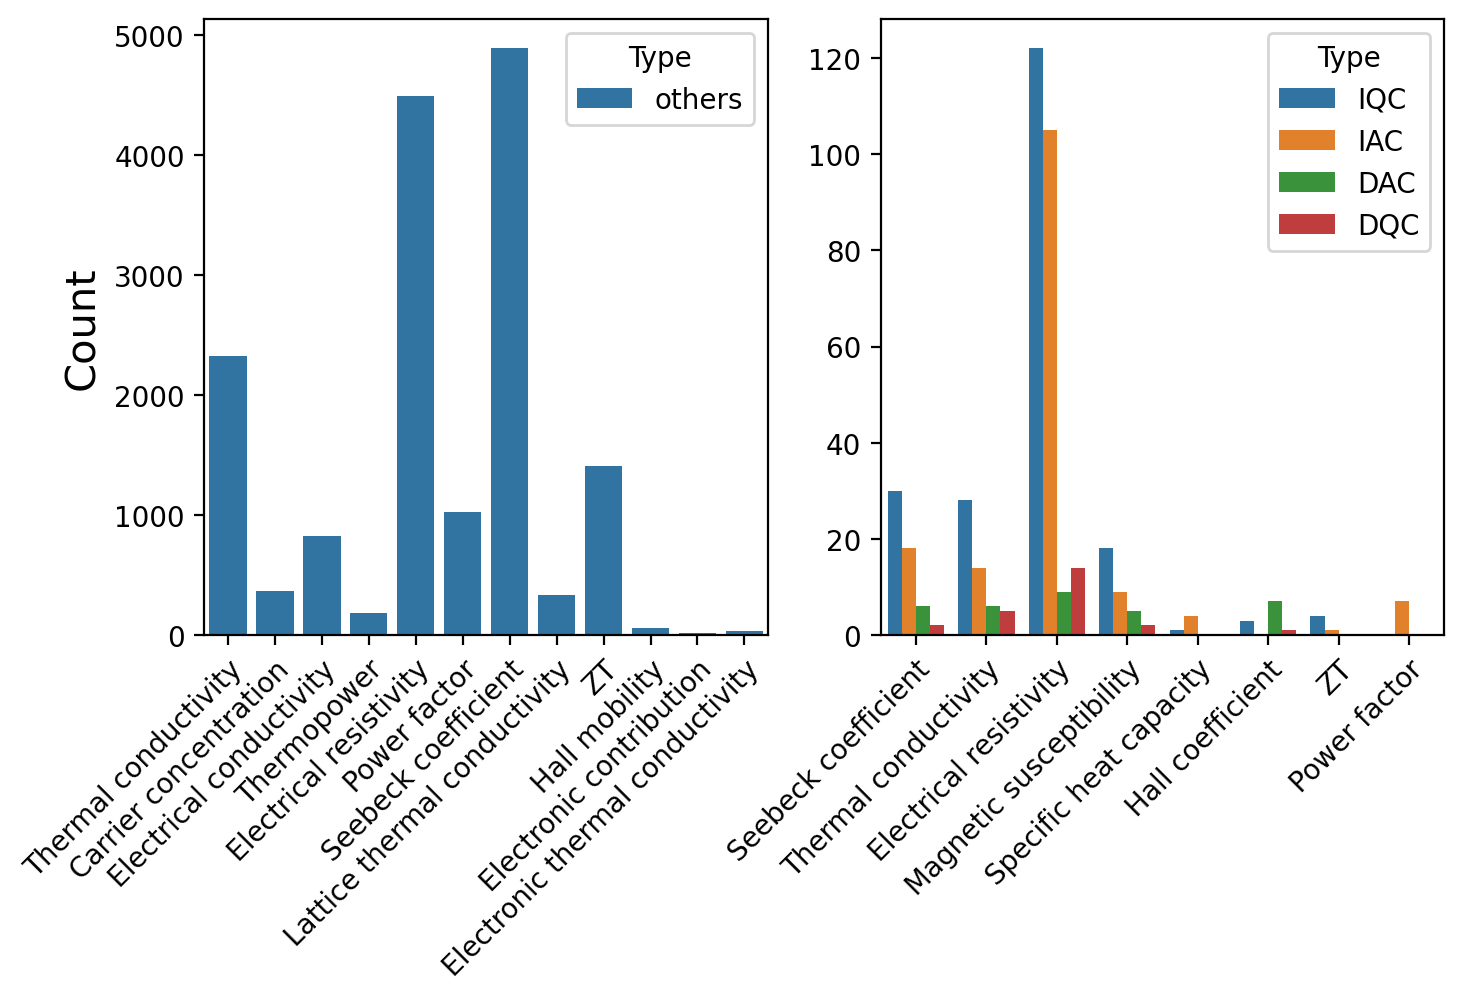

In [277]:
tmp_ = qc_ac_te_mp_dataset[qc_ac_te_mp_dataset.temperature != 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=200, sharey=False)

tmp = tmp_[tmp_.hypermaterial_type == 'others']
ax = sns.countplot(tmp, x="property", hue='hypermaterial_type', ax=ax1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel("Count", fontsize=15)
ax.set_xlabel(None)
ax.legend(title='Type')

tmp = tmp_[tmp_.hypermaterial_type != 'others']
ax = sns.countplot(tmp, x="property", hue='hypermaterial_type', ax=ax2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.legend(title='Type')

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:120: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


Text(0, 0.5, 'Count')

Text(0.5, 0, '# of properties in a composition')

Text(0.5, 0, '')

Text(0, 0.5, '')

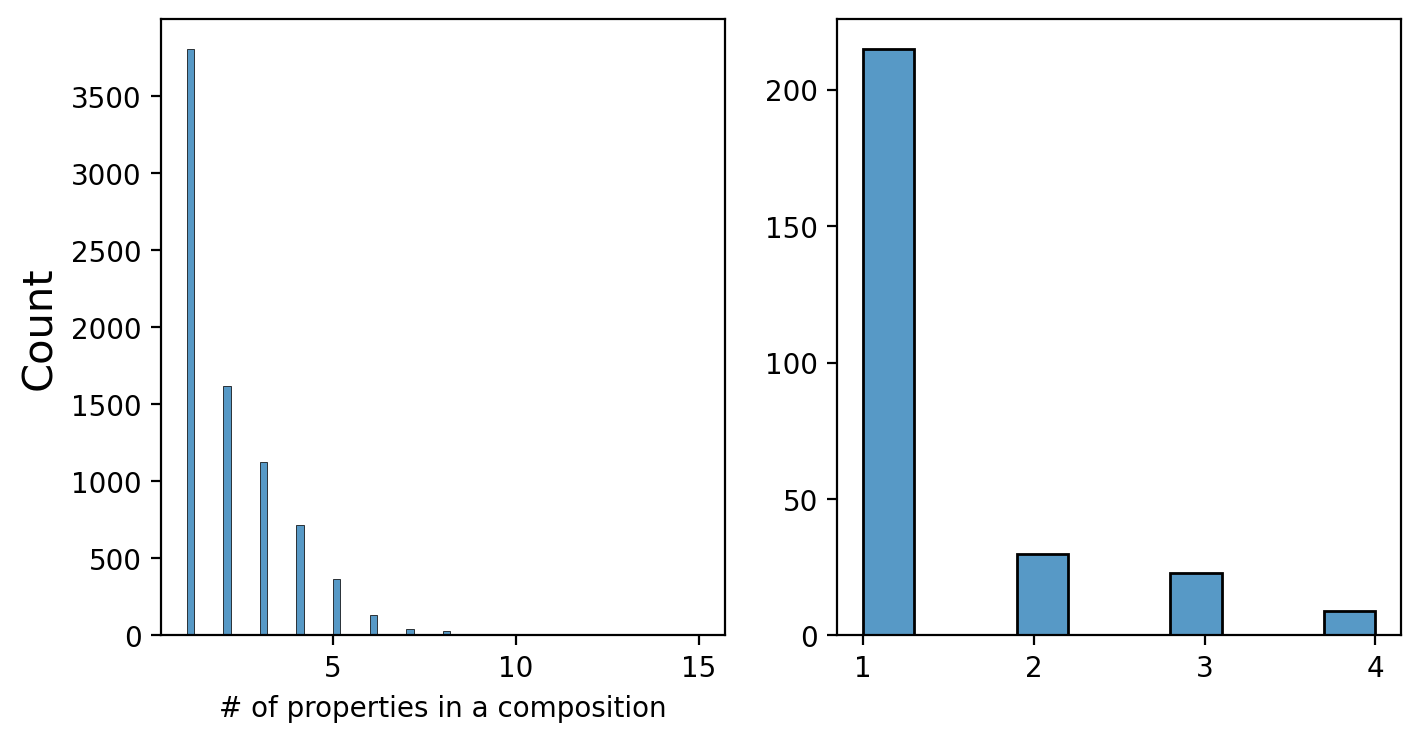

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=200)

tmp = qc_ac_te_dataset[qc_ac_te_dataset.hypermaterial_type == 'others']
tmp = tmp.groupby('composition').property.nunique()

ax = sns.histplot(tmp, ax=ax1)
ax.set_ylabel("Count", fontsize=15)
ax.set_xlabel('# of properties in a composition')

tmp = qc_ac_te_dataset[qc_ac_te_dataset.hypermaterial_type != 'others']
tmp = tmp.groupby('composition').property.nunique()
ax = sns.histplot(tmp, ax=ax2)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel(None)
ax.set_ylabel(None)

---

In [14]:
qc_ac_te_mp_rebuild = []

for (formula, hypermaterial_type, temperature), data in qc_ac_te_mp_dataset.groupby(['formula', 'hypermaterial_type', 'temperature']):
    row_1 = data.iloc[0]
    a = {
        'formula': formula,
        'hypermaterial_type': hypermaterial_type,
        'temperature': temperature,
        'composition': row_1.composition,
        'elements': row_1.elements,
    }
    for _id, row in data.iterrows():
        a[row.property] = row.property_value
        a['id'] = _id

    qc_ac_te_mp_rebuild.append(a)

qc_ac_te_mp_rebuild = pd.DataFrame(qc_ac_te_mp_rebuild).set_index('id')
qc_ac_te_mp_rebuild.to_pickle("../raw/qc_ac_te_mp_rebuild_T=290K_20250202.pd.xz")
qc_ac_te_mp_rebuild.head(3)

,formula,hypermaterial_type,temperature,composition,elements,Thermal conductivity,Seebeck coefficient,Carrier concentration,Electrical conductivity,Thermopower,...,Density,Efermi,Final energy per atom,Formation energy per atom,Total magnetization,Volume,Magnetic susceptibility,Hall coefficient,Electronic contribution,Electronic thermal conductivity
id,,,,,,,,,,,,,,,,,,,,,
starry_0,(ErAs)0.003InGaAs,others,290,"(Er, As, In, Ga)","(Er, As, In, Ga)",3.2670491071158483,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qa_1,Al61.5Cu26.5Fe12,IQC,290,"(Al, Cu, Fe)","(Al, Cu, Fe)",1.4258964578008275,-1.1863527516689362e-05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
starry_2,Bi2Te2.4Se0.6,others,290,"(Bi, Te, Se)","(Bi, Te, Se)",NaN,NaN,-5.436073908332581e+24,1063.8779641515926,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(Thermal conductivity    5.199338
 dtype: float64,
 Thermal conductivity   -5.199338
 dtype: float64)

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

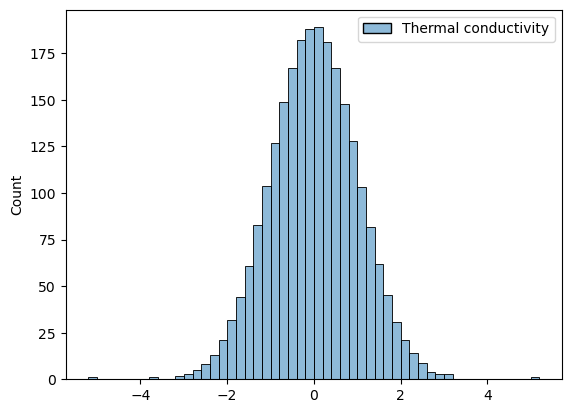

In [321]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal').set_output(transform="pandas")

a = qc_ac_te_mp_rebuild[['Thermal conductivity']].dropna().astype(np.float64)
a = qt.fit_transform(a)
a.max(), a.min()
sns.histplot(a)

(Electrical resistivity    5.199338
 dtype: float64,
 Electrical resistivity   -5.199338
 dtype: float64)

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

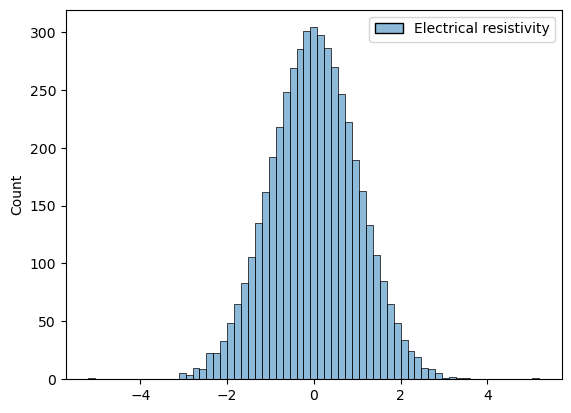

In [322]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal').set_output(transform="pandas")

a = qc_ac_te_mp_rebuild[['Electrical resistivity']].dropna().astype(np.float64)
a = qt.fit_transform(a)
a.max(), a.min()
sns.histplot(a)

(Seebeck coefficient    5.199338
 dtype: float64,
 Seebeck coefficient   -5.199338
 dtype: float64)

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

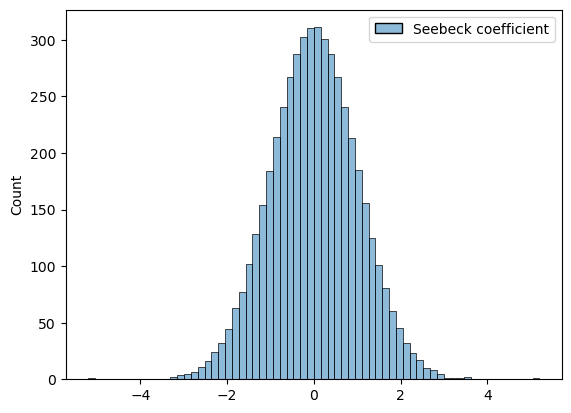

In [323]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal').set_output(transform="pandas")

a = qc_ac_te_mp_rebuild[['Seebeck coefficient']].dropna().astype(np.float64)
a = qt.fit_transform(a)
a.max(), a.min()
sns.histplot(a)